In [193]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [276]:
%matplotlib inline
import numpy as np
from sympy.solvers import solve
from sympy import Symbol
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import timeit 
from sklearn import svm
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
%config InlineBackend.figure_formats = {'png', 'retina'}

# Training and Testing Data Split

In [194]:
mobile_train=pd.read_csv('train.csv', header=0)
X=np.array(mobile_train.drop(columns='price_range')) # For PCA
Xtype=np.array(mobile_train['price_range']) # To be used in kNN implimentation

In [195]:
X, Xtest, Xtype, Xtestype = train_test_split(X, Xtype, test_size = 0.2, random_state = 0)

In [196]:
print(mobile_train.columns)

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')


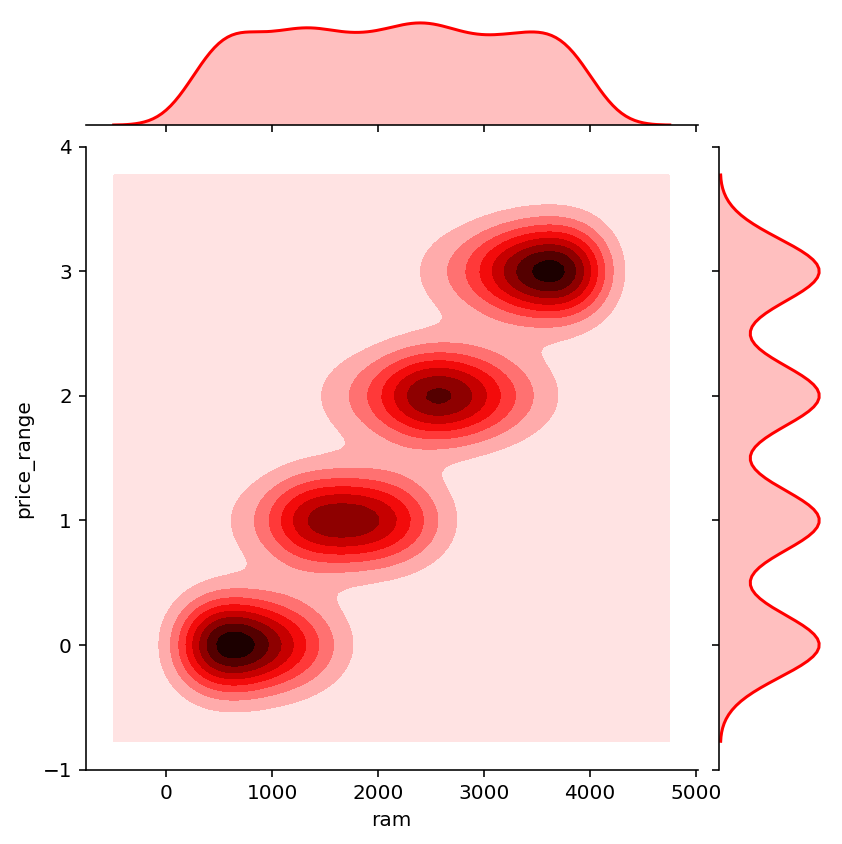

In [198]:
sns.jointplot(x='ram',y='price_range', data=mobile_train,color='red',kind='kde')

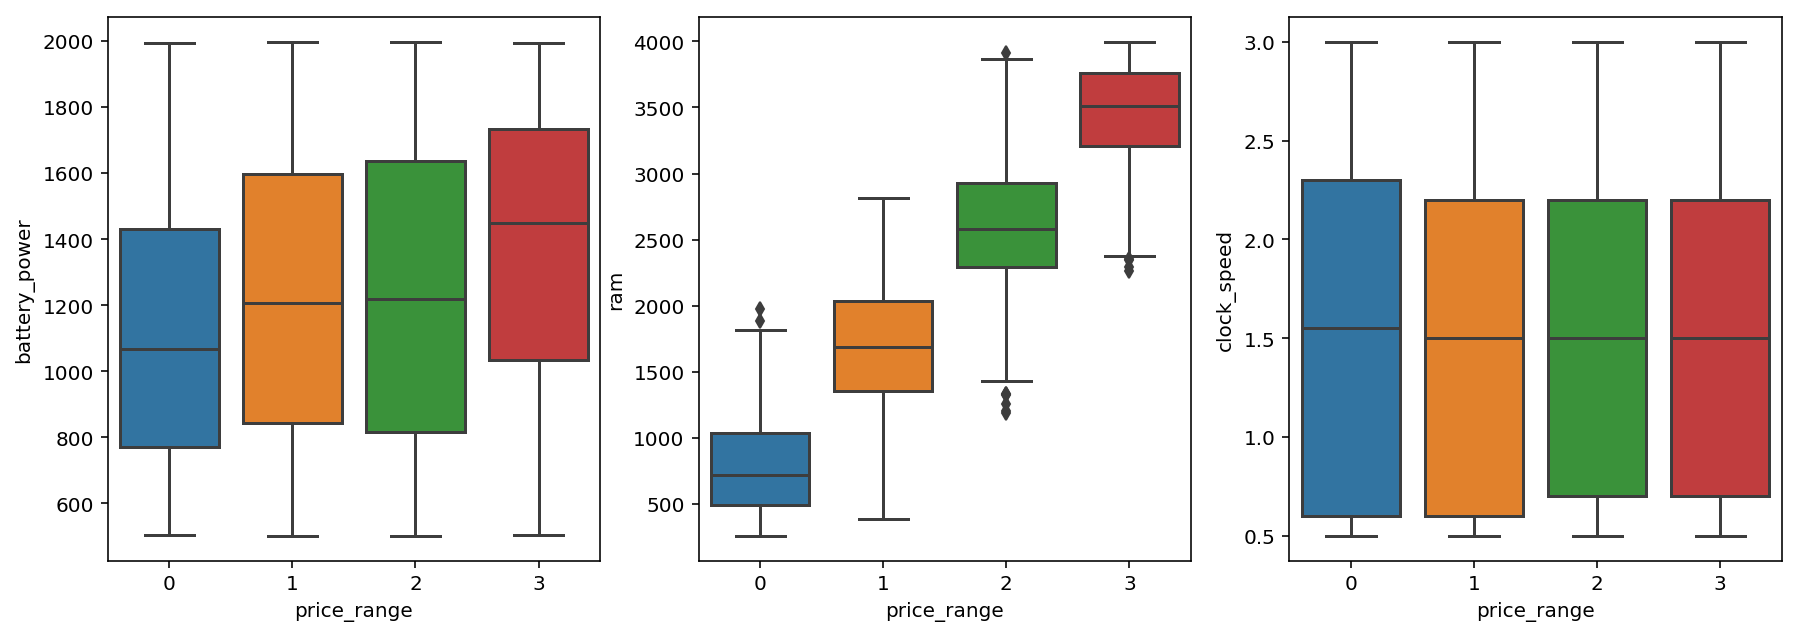

In [199]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(x="price_range", y="battery_power", data=mobile_train)
plt.subplot(132)
sns.boxplot(x="price_range", y="ram", data=mobile_train)
plt.subplot(133)
sns.boxplot(x="price_range", y="clock_speed", data=mobile_train)

# Find sigma and mu for Normalization of Training and Testing data

In [200]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu, sigma=EstGauss(X)

# Normalization: Training Data

In [201]:
std=np.sqrt(sigma.diagonal())
nX=np.zeros_like(X)

for i in range(len(X)):
    nX[i]=np.divide(X[i]-mu, std)  

# Normalization: Testing Data

In [202]:
nXtest=np.zeros_like(Xtest)

for i in range(len(Xtest)):
    nXtest[i]=np.divide(Xtest[i]-mu, std)  

# PCA

In [203]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

nmu, nsigma = EstGauss(nX)

# Eigen decomposition for PCA
w, v = np.linalg.eig(nsigma)
# Ordering the eigen values from highest to lowest
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]

frac=[i/np.sum(w) for i in w]

# Determine the 'm' value for the matrix dimensions.
fraction=0.0
error=1.0-fraction
for i in range(len(frac)):
    if error>=0.1:
        fraction+=frac[i]
        error=1-fraction
        m=i

print('Only '+ str(m+1)+ ' features are needed for PCA based on the error rate out of the ' + str(len(w))+' features')

pX=np.matmul(v[:m+1,:], nX.transpose())  # The multiplication of the principal axes to transform the data.
pX=pX.transpose()

pXtest=np.matmul(v[:m+1,:], nXtest.transpose())  # The multiplication of the principal axes to transform the data.
pXtest=pXtest.transpose()

Only 16 features are needed for PCA based on the error rate out of the 20 features


# FLD

In [204]:
classwise=np.insert(nX, nX.shape[1], Xtype, axis=1)#, axis=0) # Adding the type to the distance
classwise=pd.DataFrame(classwise)
classwise.rename(columns={nX.shape[1]:"price_range"}, inplace=True)

nX0=np.array(classwise[classwise['price_range']==0].drop(columns='price_range')) # Class separated, for FLD and kNN
nX1=np.array(classwise[classwise['price_range']==1].drop(columns='price_range')) # Class separated, for FLD and kNN
nX2=np.array(classwise[classwise['price_range']==2].drop(columns='price_range')) # Class separated, for FLD and kNN
nX3=np.array(classwise[classwise['price_range']==3].drop(columns='price_range')) # Class separated, for FLD and kNN

mu0, sigma0=EstGauss(nX0)
mu1, sigma1=EstGauss(nX1)
mu2, sigma2=EstGauss(nX2)
mu3, sigma3=EstGauss(nX3)

SW=sigma0+sigma1+sigma2+sigma3
SB=nX0.shape[0]*(mu0-mu)+nX1.shape[0]*(mu1-mu)+nX2.shape[0]*(mu2-mu)+nX3.shape[0]*(mu3-mu)
SWinv=np.linalg.inv(SW)
omega=np.matmul(SWinv, (mu0-mu1).reshape(20,1))
#
fX=np.matmul(omega.transpose(), nX.transpose())
fX=fX.transpose()
#
fXtest=np.matmul(omega.transpose(), nXtest.transpose())
fXtest=fXtest.transpose()


# Bayesian Classifier: Three cases 

## Case-1 : $\Sigma_1$ = $\Sigma_2$= $\sigma^2I$

In [205]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)
mu2,sigma2=EstGauss(nX2)
mu3,sigma3=EstGauss(nX3)

sig=np.sum((sigma0+sigma1+sigma2+sigma3).diagonal())/20.0
sigma=sig*(np.identity(20, dtype=float))
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata1=pd.DataFrame()
booldata1['0']=g0(nXtest,0.25)
booldata1['1']=g1(nXtest,0.25)
booldata1['2']=g2(nXtest,0.25)
booldata1['3']=g3(nXtest,0.25)
boolcase1 = np.array(booldata1.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case1=confusion_matrix(testbool,boolcase1)

accu_case1=testbool-boolcase1
unique1, counts1 = np.unique(accu_case1, return_counts=True)
case1=dict(zip(unique1, counts1))

accuracy_case1= case1[0]/sum(case1.values())
print('Case 1 : Overall Accuracy = ' + str(accuracy_case1))

Case 1 : Overall Accuracy = 0.75


## Case-2 : $\Sigma_1$ $=$ $\Sigma_2$

In [206]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)
mu2,sigma2=EstGauss(nX2)
mu3,sigma3=EstGauss(nX3)

sigma=(sigma0+sigma1+sigma2+sigma3)/4.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata2=pd.DataFrame()
booldata2['0']=g0(nXtest,0.25)
booldata2['1']=g1(nXtest,0.25)
booldata2['2']=g2(nXtest,0.25)
booldata2['3']=g3(nXtest,0.25)
boolcase2 = np.array(booldata2.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case2=confusion_matrix(testbool,boolcase2)

accu_case2=testbool-boolcase2
unique2, counts2 = np.unique(accu_case2, return_counts=True)
case2=dict(zip(unique2, counts2))

accuracy_case2= case2[0]/sum(case2.values())
print('Case 2 : Overall Accuracy = ' + str(accuracy_case2))

Case 2 : Overall Accuracy = 0.945


## Case-3 : $\Sigma_1$ $\neq$ $\Sigma_2$

In [207]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(nX0)
mu1,sigma1=EstGauss(nX1)
mu2,sigma2=EstGauss(nX2)
mu3,sigma3=EstGauss(nX3)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma2det=np.linalg.det(sigma2)
sigma3det=np.linalg.det(sigma3)

sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)
sigma2inv=np.linalg.inv(sigma2)
sigma3inv=np.linalg.inv(sigma3)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata3=pd.DataFrame()
booldata3['0']=g0(nXtest,0.25)
booldata3['1']=g1(nXtest,0.25)
booldata3['2']=g2(nXtest,0.25)
booldata3['3']=g3(nXtest,0.25)
boolcase3 = np.array(booldata3.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case3=confusion_matrix(testbool,boolcase3)

accu_case3=testbool-boolcase3
unique3, counts3 = np.unique(accu_case3, return_counts=True)
case3=dict(zip(unique3, counts3))

accuracy_case3= case3[0]/sum(case3.values())
print('Case 3 : Overall Accuracy = ' + str(accuracy_case3))

Case 3 : Overall Accuracy = 0.935


# Reduced Data: PCA

In [208]:
classwise=np.insert(pX, pX.shape[1], Xtype, axis=1)#, axis=0) # Adding the type to the distance
classwise=pd.DataFrame(classwise)
classwise.rename(columns={pX.shape[1]:'price_range'}, inplace=True)

pX0=np.array(classwise[classwise['price_range']==0.0].drop(columns='price_range')) # Class separated, for FLD and kNN
pX1=np.array(classwise[classwise['price_range']==1.0].drop(columns='price_range')) # Class separated, for FLD and kNN
pX2=np.array(classwise[classwise['price_range']==2.0].drop(columns='price_range')) # Class separated, for FLD and kNN
pX3=np.array(classwise[classwise['price_range']==3.0].drop(columns='price_range')) # Class separated, for FLD and kNN

## Case-1 : $\Sigma_1$ = $\Sigma_2$= $\sigma^2I$

In [209]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)
mu2,sigma2=EstGauss(pX2)
mu3,sigma3=EstGauss(pX3)

sig=np.sum((sigma0+sigma1+sigma2+sigma3).diagonal())/pX.shape[1]
sigma=sig*(np.identity(pX.shape[1], dtype=float))
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata1=pd.DataFrame()
booldata1['0']=g0(pXtest,0.25)
booldata1['1']=g1(pXtest,0.25)
booldata1['2']=g2(pXtest,0.25)
booldata1['3']=g3(pXtest,0.25)
boolcase1 = np.array(booldata1.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case1=confusion_matrix(testbool,boolcase1)

accu_case1=testbool-boolcase1
unique1, counts1 = np.unique(accu_case1, return_counts=True)
case1=dict(zip(unique1, counts1))

accuracy_case1= case1[0]/sum(case1.values())
print('PCA Case 1 : Overall Accuracy = ' + str(accuracy_case1))

PCA Case 1 : Overall Accuracy = 0.5375


## Case-2 : $\Sigma_1$ $=$ $\Sigma_2$

In [210]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)
mu2,sigma2=EstGauss(pX2)
mu3,sigma3=EstGauss(pX3)

sigma=(sigma0+sigma1+sigma2+sigma3)/4.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata2=pd.DataFrame()
booldata2['0']=g0(pXtest,0.25)
booldata2['1']=g1(pXtest,0.25)
booldata2['2']=g2(pXtest,0.25)
booldata2['3']=g3(pXtest,0.25)
boolcase2 = np.array(booldata2.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case2=confusion_matrix(testbool,boolcase2)

accu_case2=testbool-boolcase2
unique2, counts2 = np.unique(accu_case2, return_counts=True)
case2=dict(zip(unique2, counts2))

accuracy_case2= case2[0]/sum(case2.values())
print('PCA Case 2 : Overall Accuracy = ' + str(accuracy_case2))

PCA Case 2 : Overall Accuracy = 0.605


## Case-3 : $\Sigma_1$ $\neq$ $\Sigma_2$

In [211]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(pX0)
mu1,sigma1=EstGauss(pX1)
mu2,sigma2=EstGauss(pX2)
mu3,sigma3=EstGauss(pX3)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma2det=np.linalg.det(sigma2)
sigma3det=np.linalg.det(sigma3)

sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)
sigma2inv=np.linalg.inv(sigma2)
sigma3inv=np.linalg.inv(sigma3)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata3=pd.DataFrame()
booldata3['0']=g0(pXtest,0.25)
booldata3['1']=g1(pXtest,0.25)
booldata3['2']=g2(pXtest,0.25)
booldata3['3']=g3(pXtest,0.25)
boolcase3 = np.array(booldata3.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case3=confusion_matrix(testbool,boolcase3)

accu_case3=testbool-boolcase3
unique3, counts3 = np.unique(accu_case3, return_counts=True)
case3=dict(zip(unique3, counts3))

accuracy_case3= case3[0]/sum(case3.values())
print('Case 3 : Overall Accuracy = ' + str(accuracy_case3))

Case 3 : Overall Accuracy = 0.6025


# Reduced Data: FLD

In [212]:
classwise=np.insert(fX, 1, Xtype, axis=1)#, axis=0) # Adding the type to the distance
classwise=pd.DataFrame(classwise)
classwise.rename(columns={1:"price_range"}, inplace=True)

fX0=np.array(classwise[classwise['price_range']==0.0].drop(columns='price_range')) # Class separated, for FLD and kNN
fX1=np.array(classwise[classwise['price_range']==1.0].drop(columns='price_range')) # Class separated, for FLD and kNN
fX2=np.array(classwise[classwise['price_range']==2.0].drop(columns='price_range')) # Class separated, for FLD and kNN
fX3=np.array(classwise[classwise['price_range']==3.0].drop(columns='price_range')) # Class separated, for FLD and kNN

## Case-1 : $\Sigma_1$ = $\Sigma_2$= $\sigma^2I$

In [213]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)
mu2,sigma2=EstGauss(fX2)
mu3,sigma3=EstGauss(fX3)

sig=np.sum((sigma0+sigma1+sigma2+sigma3).diagonal())/fX.shape[1]
sigma=sig*(np.identity(fX.shape[1], dtype=float))
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#------------------------------------------------------------------------------------------------------------------------------

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata1=pd.DataFrame()
booldata1['0']=g0(fXtest,0.25)
booldata1['1']=g1(fXtest,0.25)
booldata1['2']=g2(fXtest,0.25)
booldata1['3']=g3(fXtest,0.25)
boolcase1 = np.array(booldata1.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case1=confusion_matrix(testbool,boolcase1)

accu_case1=testbool-boolcase1
unique1, counts1 = np.unique(accu_case1, return_counts=True)
case1=dict(zip(unique1, counts1))

accuracy_case1= case1[0]/sum(case1.values())
print('FLD Case 1 : Overall Accuracy = ' + str(accuracy_case1))

FLD Case 1 : Overall Accuracy = 0.955


## Case-2 : $\Sigma_1$ $=$ $\Sigma_2$

In [214]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)
mu2,sigma2=EstGauss(fX2)
mu3,sigma3=EstGauss(fX3)

sigma=(sigma0+sigma1+sigma2+sigma3)/4.
sigmadet=np.linalg.det(sigma)
sigmainv=np.linalg.inv(sigma)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigmainv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigmainv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata2=pd.DataFrame()
booldata2['0']=g0(fXtest,0.25)
booldata2['1']=g1(fXtest,0.25)
booldata2['2']=g2(fXtest,0.25)
booldata2['3']=g3(fXtest,0.25)
boolcase2 = np.array(booldata2.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case2=confusion_matrix(testbool,boolcase2)

accu_case2=testbool-boolcase2
unique2, counts2 = np.unique(accu_case2, return_counts=True)
case2=dict(zip(unique2, counts2))

accuracy_case2= case2[0]/sum(case2.values())
print('FLD Case 2 : Overall Accuracy = ' + str(accuracy_case2))

FLD Case 2 : Overall Accuracy = 0.955


## Case-3 : $\Sigma_1$ $\neq$ $\Sigma_2$

In [215]:
def EstGauss(data):
    mu=np.mean(data, axis=0)
    m,n=data.shape
    sigma=np.zeros((n,n))
    
    for i in range(m):
        sigma = sigma + (data[i] - mu).reshape(n,1).dot((data[i] - mu).reshape(1,n))
        
    sigma=sigma*(1.0/m)
    
    return mu, sigma

mu0,sigma0=EstGauss(fX0)
mu1,sigma1=EstGauss(fX1)
mu2,sigma2=EstGauss(fX2)
mu3,sigma3=EstGauss(fX3)

sigma0det=np.linalg.det(sigma0)
sigma1det=np.linalg.det(sigma1)
sigma2det=np.linalg.det(sigma2)
sigma3det=np.linalg.det(sigma3)

sigma0inv=np.linalg.inv(sigma0)
sigma1inv=np.linalg.inv(sigma1)
sigma2inv=np.linalg.inv(sigma2)
sigma3inv=np.linalg.inv(sigma3)

#Categorizing based on the Discriminant Function

def g0(data, Prior):
    k,l=data.shape
    g0=np.zeros(k)
    for i in range(k):
        g0[i]=-0.5*(data[i]-mu0).reshape(1,l).dot(sigma0inv).dot((data[i]-mu0).reshape(l,1))-0.5*np.log(sigma0det)+np.log(Prior)
    return g0

def g1(data, Prior):
    k,l=data.shape
    g1=np.zeros(k)
    for i in range(k):
        g1[i]=-0.5*(data[i]-mu1).reshape(1,l).dot(sigma1inv).dot((data[i]-mu1).reshape(l,1))-0.5*np.log(sigma1det)+np.log(Prior)
    return g1

def g2(data, Prior):
    k,l=data.shape  # k = number of training samples, l = dimension (# of features)
    g2=np.zeros(k)
    for i in range(k):
        g2[i]=-0.5*(data[i]-mu2).reshape(1,l).dot(sigmainv).dot((data[i]-mu2).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g2

def g3(data, Prior):
    k,l=data.shape
    g3=np.zeros(k)
    for i in range(k):
        g3[i]=-0.5*(data[i]-mu3).reshape(1,l).dot(sigmainv).dot((data[i]-mu3).reshape(l,1))-0.5*np.log(sigmadet)+np.log(Prior)
    return g3

booldata3=pd.DataFrame()
booldata3['0']=g0(fXtest,0.25)
booldata3['1']=g1(fXtest,0.25)
booldata3['2']=g2(fXtest,0.25)
booldata3['3']=g3(fXtest,0.25)
boolcase3 = np.array(booldata3.idxmax(axis=1)).astype(int)

#-----------------------------------Accuracy Calculation for Case-1------------------------------------------------------
testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_case3=confusion_matrix(testbool,boolcase3)

accu_case3=testbool-boolcase3
unique3, counts3 = np.unique(accu_case3, return_counts=True)
case3=dict(zip(unique3, counts3))

accuracy_case3= case3[0]/sum(case3.values())
print('FLD Case 3 : Overall Accuracy = ' + str(accuracy_case3))

FLD Case 3 : Overall Accuracy = 0.96


## SVM Classification using Scikitlearn package

In [278]:
import numpy as np
from sklearn.svm import SVC

clf = SVC(gamma='scale', C = 5.)
clf.fit(nX, Xtype) 
boolSVM=clf.predict(nXtest)

testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.
confusion_SVM=confusion_matrix(testbool,boolSVM)
accu_SVM=testbool-boolSVM
uniqueSVM, countsSVM = np.unique(accu_SVM, return_counts=True)
SVM=dict(zip(uniqueSVM, countsSVM))

accuracy_SVM= SVM[0]/sum(SVM.values())
print('SVM : Overall Accuracy = ' + str(accuracy_SVM))

SVM : Overall Accuracy = 0.895


## Decision Tree Classification using Scikitlearn package

In [241]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(nX, Xtype)

boolTREE=clf.predict(nXtest)

testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_TREE=confusion_matrix(testbool,boolTREE)
accu_TREE=testbool-boolTREE
uniqueTREE, countsTREE = np.unique(accu_TREE, return_counts=True)
TREE=dict(zip(uniqueTREE, countsTREE))

accuracy_TREE = TREE[0]/sum(TREE.values())
print('TREE : Overall Accuracy = ' + str(accuracy_TREE))

TREE : Overall Accuracy = 0.8225


## BPNN Classification using Scikitlearn package

In [275]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(3, 5), random_state=4)
clf.fit(nX, Xtype)  

boolBPNN=clf.predict(nXtest)

testbool=Xtestype # This is used to calculate the accuracy by comparing this with the different case discriminants.

confusion_BPNN=confusion_matrix(testbool,boolBPNN)
accu_BPNN=testbool-boolBPNN
uniqueBPNN, countsBPNN = np.unique(accu_BPNN, return_counts=True)
BPNN=dict(zip(uniqueBPNN, countsBPNN))

accuracy_BPNN = BPNN[0]/sum(BPNN.values())
print('BPNN : Overall Accuracy = ' + str(accuracy_BPNN))

BPNN : Overall Accuracy = 0.975
